In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import os
from os import listdir
from os.path import isfile, join

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [2]:
# Resized images directory
dir_2019_images = "/kaggle/input/resizedsiimisic/train_resized/"
dir_2019_aug_images = "/kaggle/input/models/oversampling/train_resized/"

# CSV files
train_df = pd.read_csv('/kaggle/input/resizedsiimisic/train.csv')
undersampling_test = pd.read_csv('/kaggle/input/models/undersampling/test.csv')
weighted_test = pd.read_csv('/kaggle/input/models/weighted/test.csv')
oversampling_test = pd.read_csv('/kaggle/input/models/oversampling/test.csv')

# Load models
undersampling = load_model('/kaggle/input/models/undersampling/undersampling_model.h5')
weighted = load_model('/kaggle/input/models/weighted/weighted_model.h5')
oversampling = load_model('/kaggle/input/models/oversampling/oversampling_model.h5')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [3]:
undersampling_test["target"] = undersampling_test['target'].astype(str)
weighted_test["target"] = weighted_test['target'].astype(str)
oversampling_test["target"] = oversampling_test['target'].astype(str)

In [4]:
datagen = ImageDataGenerator(rescale=1./255.)

test_generator_under = datagen.flow_from_dataframe(
    dataframe=undersampling_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator_weight = datagen.flow_from_dataframe(
    dataframe=weighted_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

test_generator_over = datagen.flow_from_dataframe(
    dataframe=oversampling_test,
    directory=dir_2019_images,
    x_col="image_name",
    y_col="target",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary"
)

Found 1043 validated image filenames belonging to 2 classes.
Found 2697 validated image filenames belonging to 2 classes.
Found 2697 validated image filenames belonging to 2 classes.


In [5]:
true_labels_test_under = test_generator_under.classes
true_labels_test_weight = test_generator_weight.classes
true_labels_test_over = test_generator_over.classes

predict_undersampling_test = undersampling.predict(test_generator_under, verbose=1)
predict_weighted_test = weighted.predict(test_generator_weight, verbose=1)
predict_oversampling_test = oversampling.predict(test_generator_over, verbose=1)

2021-12-03 22:04:27.791280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


85/85 [==============================] - 201s 2s/step


In [6]:
df_2019 = train_df.rename(columns={"anatom_site_general_challenge": "location"})

In [7]:
print("Train shape:", df_2019.shape)
df_2019.head()

Train shape: (22480, 5)


,image_name,sex,age_approx,location,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


## <font color=red>2. </font>Red bayesiana 

basado en: http://webia.lip6.fr/~phw/aGrUM/docs/last/notebooks/Tutorial.ipynb.html

In [8]:
# Unique values in each features
for k in df_2019.keys():
    print('{0}: {1}'.format(k, len(df_2019[k].unique())))

image_name: 22480
sex: 2
age_approx: 18
location: 8
target: 2


In [9]:
def for_age(row):
    try:
        age = float(row['age_approx'])
        if age < 18:
            return 'teen'
        elif age < 30:
            return 'twenties'
        elif age < 40:
            return 'thirties'
        elif age < 50:
            return 'forties'
        elif age < 60:
            return 'fifties'
        elif age < 70:
            return 'sixties'
        else:
            return 'old'
    except ValueError:
        return np.nan
    
def for_boolean(row, col):
    try:
        val = int(row[col])
        if row[col] >= 1:
            return "True"
        else:
            return "False"
    except ValueError:
        return "False"

In [10]:
def pretreat(df):
    if 'target' in df.columns:
        df['target'] = df.apply(lambda row: for_boolean(row, 'target'), axis=1)
    df['age_approx'] = df.apply(for_age, axis=1)
    return df

In [11]:
df_2019.head()

,image_name,sex,age_approx,location,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


In [12]:
!pip install pyAgrum
!pip install pydotplus

     |████████████████████████████████| 5.2 MB 908 kB/s            
     |████████████████████████████████| 278 kB 67.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=1f63b188ca02c96435b72d170abfa5674ae460856dacde490d83cd82d8f59895
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


### Naive Bayes

In [13]:
undersampling_test["target"] = undersampling_test['target'].astype(float)
weighted_test["target"] = weighted_test['target'].astype(float)
oversampling_test["target"] = oversampling_test['target'].astype(float)

undersampling_test = pretreat(undersampling_test)
weighted_test = pretreat(weighted_test)
oversampling_test = pretreat(oversampling_test)

#### Se realiza el cálculo manualmente con un caso, por ejemplo, en el conjunto de prueba del modelo de submuestreo: en el caso de la mujer se observa que tiene cáncer y la predicción del clasificador de imágenes es de un 93%.

In [14]:
print("Label:", np.array(true_labels_test_under)[1])
print("Predicted:", predict_undersampling_test[1][0])
undersampling_test.head(2)

Label: 1
Predicted: 0.9745324


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0059730.jpg,male,sixties,lower extremity,False
1,ISIC_0031543.jpg,female,sixties,upper extremity,True


#### A continuación, se calculan las probabilidades a partir de los datos tabulares para usarlas en Naive Bayes.

In [15]:
cancer_df = df_2019.loc[df_2019['target'] == 1]
non_cancer_df = df_2019.loc[df_2019['target'] == 0]

In [16]:
cancer_df = pretreat(cancer_df)
non_cancer_df = pretreat(non_cancer_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
cancer_age = dict(cancer_df.groupby(['age_approx']).size() / len(cancer_df))
cancer_sex = dict(cancer_df.groupby(['sex']).size() / len(cancer_df))
cancer_location = dict(cancer_df.groupby(['location']).size() / len(cancer_df))

non_cancer_age = dict(non_cancer_df.groupby(['age_approx']).size() / len(non_cancer_df))
non_cancer_sex = dict(non_cancer_df.groupby(['sex']).size() / len(non_cancer_df))
non_cancer_location = dict(non_cancer_df.groupby(['location']).size() / len(non_cancer_df))

#### Se obtienen las evidencias del caso para el cálculo de la probabilidad a posteriori:

In [18]:
age = undersampling_test.values[1][2]
sex = undersampling_test.values[1][1]
loc = undersampling_test.values[1][3]

evid = {'age':age, 'sex':sex, 'location':loc}
evid

{'age': 'sixties', 'sex': 'female', 'location': 'upper extremity'}

In [19]:
# Naive Bayes
num = (cancer_age[evid['age']]*cancer_sex[evid['sex']]*cancer_location[evid['location']]) * predict_undersampling_test[1][0]
evidence = num + (non_cancer_age[evid['age']]*non_cancer_sex[evid['sex']]*non_cancer_location[evid['location']]) * (1-predict_undersampling_test[1][0])
print("Clasificador:", predict_undersampling_test[1][0])
print("Posteriori:", num/evidence)

Clasificador: 0.9745324
Posteriori: 0.9842374457931136


#### Se realiza e imprimen las nuevas predicciones para el conjunto de prueba del modelo de submuestreo teniendo en cuenta las evidencias de cada caso. 

In [20]:
new_predictions_under = []
row = 0

for i in predict_undersampling_test:
    print("Etiqueta ->", np.array(true_labels_test_under)[row])
    print("Prediccion del clasificador de imagenes ->", i[0])
    
    age = undersampling_test.values[row][2]
    sex = undersampling_test.values[row][1]
    loc = undersampling_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    print("Caso", row, "|" ,evidence)
    
    num = (cancer_age[evidence['age']]*cancer_sex[evidence['sex']]*cancer_location[evidence['location']]) * i[0]
    ev = num + (non_cancer_age[evidence['age']]*non_cancer_sex[evidence['sex']]*non_cancer_location[evidence['location']]) * (1-i[0])
    pred = num/ev
    
    print("Prediccion a posteriori ->", pred)
    print("-------------------------")
    row += 1
    new_predictions_under.append(pred)

Etiqueta -> 0
Prediccion del clasificador de imagenes -> 0.39275226
Caso 0 | {'age': 'sixties', 'sex': 'male', 'location': 'lower extremity'}
Prediccion a posteriori -> 0.3997780721491671
-------------------------
Etiqueta -> 1
Prediccion del clasificador de imagenes -> 0.9745324
Caso 1 | {'age': 'sixties', 'sex': 'female', 'location': 'upper extremity'}
Prediccion a posteriori -> 0.9842374457931136
-------------------------
Etiqueta -> 0
Prediccion del clasificador de imagenes -> 0.24838415
Caso 2 | {'age': 'thirties', 'sex': 'female', 'location': 'lower extremity'}
Prediccion a posteriori -> 0.10888050993712227
-------------------------
Etiqueta -> 1
Prediccion del clasificador de imagenes -> 0.9796583
Caso 3 | {'age': 'fifties', 'sex': 'male', 'location': 'posterior torso'}
Prediccion a posteriori -> 0.9757653831125327
-------------------------
Etiqueta -> 0
Prediccion del clasificador de imagenes -> 0.65815455
Caso 4 | {'age': 'old', 'sex': 'female', 'location': 'head/neck'}
Predic

#### A continuación, se realiza las predicciones (sin imprimir el proceso) para el conjunto de prueba de los otros 2 modelos.

In [21]:
new_predictions_weight = []
row = 0

for i in predict_weighted_test:
    age = weighted_test.values[row][2]
    sex = weighted_test.values[row][1]
    loc = weighted_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    num = (cancer_age[evidence['age']]*cancer_sex[evidence['sex']]*cancer_location[evidence['location']]) * i[0]
    ev = num + (non_cancer_age[evidence['age']]*non_cancer_sex[evidence['sex']]*non_cancer_location[evidence['location']]) * (1-i[0])
    pred = num/ev
    
    row += 1
    new_predictions_weight.append(pred)

In [22]:
new_predictions_over = []
row = 0

for i in predict_oversampling_test: 
    age = oversampling_test.values[row][2]
    sex = oversampling_test.values[row][1]
    loc = oversampling_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    num = (cancer_age[evidence['age']]*cancer_sex[evidence['sex']]*cancer_location[evidence['location']]) * i[0]
    ev = num + (non_cancer_age[evidence['age']]*non_cancer_sex[evidence['sex']]*non_cancer_location[evidence['location']]) * (1-i[0])
    pred = num/ev
    
    row += 1
    new_predictions_over.append(pred)

#### Calculamos la matriz de confusión para el conjunto de prueba de cada modelo.

Predicciones del clasificador de imagenes (submuestreo)


<AxesSubplot:>

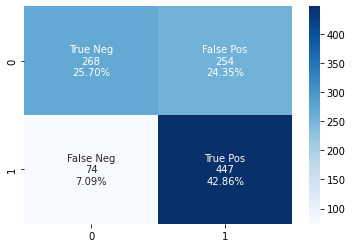

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm_before_under = confusion_matrix(true_labels_test_under, 
                                   np.where(np.array(predict_undersampling_test) > 0.5, 1, 0))

cm = [cm_before_under[0][0], cm_before_under[0][1], cm_before_under[1][0], cm_before_under[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones del clasificador de imagenes (submuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

Predicciones despues de Naive Bayes  (submuestreo)


<AxesSubplot:>

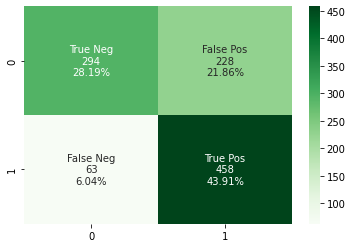

In [24]:
cm_bayes_under = confusion_matrix(true_labels_test_under, 
                                  np.where(np.array(new_predictions_under) > 0.5, 1, 0))

cm = [cm_bayes_under[0][0], cm_bayes_under[0][1], cm_bayes_under[1][0], cm_bayes_under[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones despues de Naive Bayes  (submuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Greens')

Predicciones del clasificador de imagenes (weighted)


<AxesSubplot:>

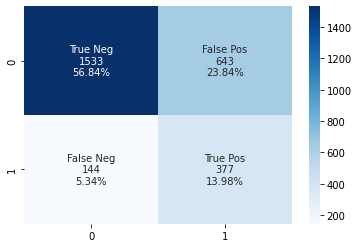

In [25]:
cm_before_weight = confusion_matrix(true_labels_test_weight, 
                                    np.where(np.array(predict_weighted_test) > 0.5, 1, 0))

cm = [cm_before_weight[0][0], cm_before_weight[0][1], cm_before_weight[1][0], cm_before_weight[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones del clasificador de imagenes (weighted)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

Predicciones despues de Naive Bayes (weighted)


<AxesSubplot:>

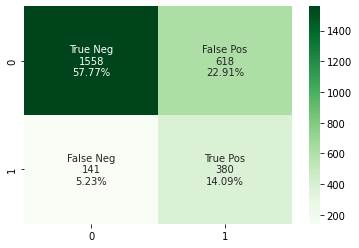

In [26]:
cm_bayes_weight = confusion_matrix(true_labels_test_weight, 
                                  np.where(np.array(new_predictions_weight) > 0.5, 1, 0))

cm = [cm_bayes_weight[0][0], cm_bayes_weight[0][1], cm_bayes_weight[1][0], cm_bayes_weight[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones despues de Naive Bayes (weighted)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Greens')

Predicciones del clasificador de imagenes (sobremuestreo)


<AxesSubplot:>

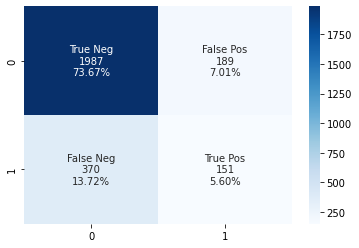

In [27]:
cm_before_over = confusion_matrix(true_labels_test_over, 
                                   np.where(np.array(predict_oversampling_test) > 0.5, 1, 0))

cm = [cm_before_over[0][0], cm_before_over[0][1], cm_before_over[1][0], cm_before_over[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones del clasificador de imagenes (sobremuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

Predicciones despues de Naive Bayes (sobremuestreo)


<AxesSubplot:>

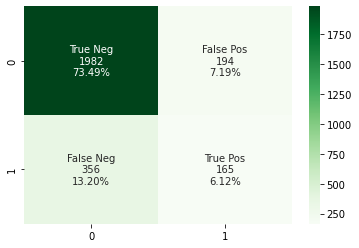

In [28]:
cm_bayes_over = confusion_matrix(true_labels_test_over, 
                                  np.where(np.array(new_predictions_over) > 0.5, 1, 0))

cm = [cm_bayes_over[0][0], cm_bayes_over[0][1], cm_bayes_over[1][0], cm_bayes_over[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones despues de Naive Bayes (sobremuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Greens')

#### Se observa, a partir de los datos tabulares Naive Bayes es capaz de mejorar las predicciones de los tres modelos.

#### A continuación, se implementa Naive Bayes con la librería pyAgrum:

In [29]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
%matplotlib inline 

bn_bayes = gum.BayesNet("Melanoma Bayes")
bn_bayes = gum.fastBN("age{teen|twenties|thirties|forties|fifties|sixties|old}<-target{False|True}->sex{female|male};location{anterior torso|head/neck|lateral torso|lower extremity|oral/genital|palms/soles|posterior torso|upper extremity}<-target")
print(bn_bayes.variable("target"))
print(bn_bayes.variable("age"))
print(bn_bayes.variable("sex"))
print(bn_bayes.variable("location"))

bn_bayes

target:Labelized(<False,True>)
age:Labelized(<teen,twenties,thirties,forties,fifties,sixties,old>)
sex:Labelized(<female,male>)
location:Labelized(<anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity>)


(pyAgrum.BayesNet<double>@0x562a42f36a00) BN{nodes: 4, arcs: 3, domainSize: 224, dim: 36}

#### Observamos el mismo ejemplo de antes.

In [30]:
print("Label:", np.array(true_labels_test_under)[1])
print("Predicted:", predict_undersampling_test[1][0])
undersampling_test.head(2)

Label: 1
Predicted: 0.9745324


,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0059730.jpg,male,sixties,lower extremity,False
1,ISIC_0031543.jpg,female,sixties,upper extremity,True


In [31]:
# Benign malignant classifier prediction
bn_bayes.cpt('target')[:] = [1-predict_undersampling_test[1][0], predict_undersampling_test[1][0]]
bn_bayes.cpt('target')

(pyAgrum.Potential<double>@0x562a3b3f2ca0) 
  target           |
False    |True     |
---------|---------|
 0.0255  | 0.9745  |

In [32]:
bn_bayes.cpt('age')[{'target':0}] = [non_cancer_age['teen'], non_cancer_age['twenties'], 
                                     non_cancer_age['thirties'], non_cancer_age['forties'],
                                     non_cancer_age['fifties'], non_cancer_age['sixties'],
                                     non_cancer_age['old']]

bn_bayes.cpt('age')[{'target':1}] = [cancer_age['teen'], cancer_age['twenties'], 
                                     cancer_age['thirties'], cancer_age['forties'],
                                     cancer_age['fifties'], cancer_age['sixties'],
                                     cancer_age['old']]
bn_bayes.cpt('age')

(pyAgrum.Potential<double>@0x562a3ba8b570) 
      ||  age                                                                |
target||teen     |twenties |thirties |forties  |fifties  |sixties  |old      |
------||---------|---------|---------|---------|---------|---------|---------|
False || 0.0256  | 0.0512  | 0.1264  | 0.1980  | 0.1824  | 0.1602  | 0.2561  |
True  || 0.0016  | 0.0145  | 0.0624  | 0.1440  | 0.1921  | 0.2009  | 0.3845  |

In [33]:
bn_bayes.cpt('sex')[{'target':0}] = [non_cancer_sex['female'], non_cancer_sex['male']]
bn_bayes.cpt('sex')[{'target':1}] = [cancer_sex['female'], cancer_sex['male']]
bn_bayes.cpt('sex')

(pyAgrum.Potential<double>@0x562a3a49c6c0) 
      ||  sex              |
target||female   |male     |
------||---------|---------|
False || 0.4728  | 0.5272  |
True  || 0.4501  | 0.5499  |

In [34]:
bn_bayes.cpt('location')[{'target':0}] = [non_cancer_location['anterior torso'], non_cancer_location['head/neck'], 
                                          non_cancer_location['lateral torso'], non_cancer_location['lower extremity'],
                                          non_cancer_location['oral/genital'], non_cancer_location['palms/soles'],
                                          non_cancer_location['posterior torso'], non_cancer_location['upper extremity']]

bn_bayes.cpt('location')[{'target':1}] = [cancer_location['anterior torso'], cancer_location['head/neck'], 
                                          cancer_location['lateral torso'], cancer_location['lower extremity'],
                                          cancer_location['oral/genital'], cancer_location['palms/soles'],
                                          cancer_location['posterior torso'], cancer_location['upper extremity']]
bn_bayes.cpt('location')

(pyAgrum.Potential<double>@0x562a400fb650) 
      ||  location                                                                     |
target||anterior |head/neck|lateral t|lower ext|oral/geni|palms/sol|posterior|upper ext|
------||---------|---------|---------|---------|---------|---------|---------|---------|
False || 0.3041  | 0.2040  | 0.0017  | 0.2300  | 0.0022  | 0.0109  | 0.1276  | 0.1195  |
True  || 0.3042  | 0.2016  | 0.0032  | 0.1811  | 0.0044  | 0.0451  | 0.0971  | 0.1634  |

In [35]:
age = undersampling_test.values[1][2]
sex = undersampling_test.values[1][1]
loc = undersampling_test.values[1][3]

evid = {'age':age, 'sex':sex, 'location':loc}
evid

{'age': 'sixties', 'sex': 'female', 'location': 'upper extremity'}

In [36]:
ie = gum.LazyPropagation(bn_bayes)

In [37]:
ie.setEvidence(evid)
ie.makeInference()
ie.posterior("target")[:]

array([0.01576255, 0.98423745])

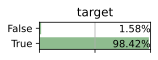

In [38]:
gnb.showPosterior(bn_bayes, evs=evid, target='target')

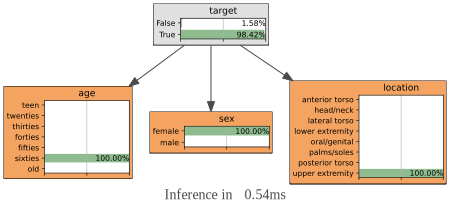

In [39]:
gnb.showInference(bn_bayes, evs=evid)

#### Se observa gráficamente que el resultado es el mismo que calculado manualmente antes. 

In [40]:
new_predictions_under_py = []
row = 0

for i in predict_undersampling_test:  
    age = undersampling_test.values[row][2]
    sex = undersampling_test.values[row][1]
    loc = undersampling_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    if i[0] == 0.5:
        bn_bayes.cpt('target')[:] = [i[0], i[0]]
    else:
        bn_bayes.cpt('target')[:] = [1-i[0], i[0]]
    
    ie = gum.LazyPropagation(bn_bayes)
    ie.setEvidence(evidence)
    ie.makeInference()
    
    row += 1
    new_predictions_under_py.append(ie.posterior("target")[:][1])

In [41]:
new_predictions_weight_py = []
row = 0

for i in predict_weighted_test:  
    age = weighted_test.values[row][2]
    sex = weighted_test.values[row][1]
    loc = weighted_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    if i[0] == 0.5:
        bn_bayes.cpt('target')[:] = [i[0], i[0]]
    else:
        bn_bayes.cpt('target')[:] = [1-i[0], i[0]]
    
    ie = gum.LazyPropagation(bn_bayes)
    ie.setEvidence(evidence)
    ie.makeInference()
    
    row += 1
    new_predictions_weight_py.append(ie.posterior("target")[:][1])

In [42]:
new_predictions_over_py = []
row = 0

for i in predict_oversampling_test:  
    age = oversampling_test.values[row][2]
    sex = oversampling_test.values[row][1]
    loc = oversampling_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    if i[0] == 0.5:
        bn_bayes.cpt('target')[:] = [i[0], i[0]]
    else:
        bn_bayes.cpt('target')[:] = [1-i[0], i[0]]
    
    ie = gum.LazyPropagation(bn_bayes)
    ie.setEvidence(evidence)
    ie.makeInference()
    
    row += 1
    new_predictions_over_py.append(ie.posterior("target")[:][1])

In [43]:
cm_bayes_pyAgrum_under = confusion_matrix(true_labels_test_under, 
                                    np.where(np.array(new_predictions_under_py) > 0.5, 1, 0))
cm_bayes_pyAgrum_under

array([[294, 228],
       [ 63, 458]])

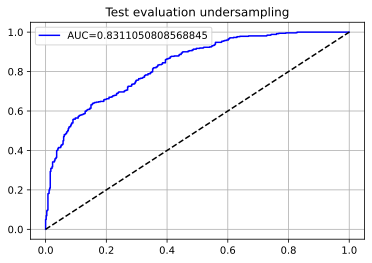

In [44]:
from sklearn import metrics

fpr, tpr, tr = metrics.roc_curve(true_labels_test_under, new_predictions_under_py)
auc = metrics.roc_auc_score(true_labels_test_under, new_predictions_under_py)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation undersampling')
plt.grid()
plt.legend(loc='best')
plt.show()

In [45]:
cm_bayes_pyAgrum_weight = confusion_matrix(true_labels_test_weight, 
                                    np.where(np.array(new_predictions_weight_py) > 0.5, 1, 0))
cm_bayes_pyAgrum_weight

array([[1558,  618],
       [ 141,  380]])

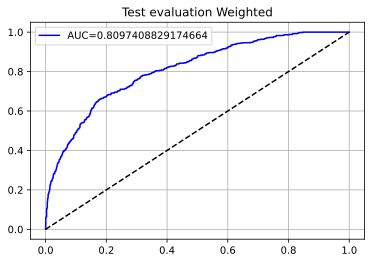

In [46]:
fpr, tpr, tr = metrics.roc_curve(true_labels_test_weight, new_predictions_weight_py)
auc = metrics.roc_auc_score(true_labels_test_weight, new_predictions_weight_py)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation Weighted')
plt.grid()
plt.legend(loc='best')
plt.show()

In [47]:
cm_bayes_pyAgrum_over = confusion_matrix(true_labels_test_over, 
                                    np.where(np.array(new_predictions_over_py) > 0.5, 1, 0))
cm_bayes_pyAgrum_over

array([[1982,  194],
       [ 356,  165]])

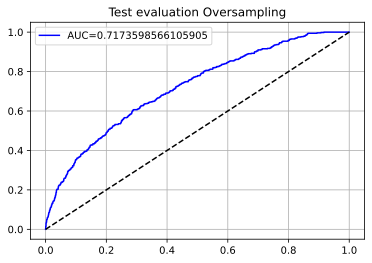

In [48]:
fpr, tpr, tr = metrics.roc_curve(true_labels_test_over, new_predictions_over_py)
auc = metrics.roc_auc_score(true_labels_test_over, new_predictions_over_py)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation Oversampling')
plt.grid()
plt.legend(loc='best')
plt.show()

#### Se obtiene las mismas matrices de confusión mediante pyAgrum.

### Red bayesiana

In [49]:
bnn = gum.BayesNet("Melanoma BNN")
bnn = gum.fastBN("target{False|True}->location{anterior torso|head/neck|lateral torso|lower extremity|oral/genital|palms/soles|posterior torso|upper extremity}->sex{female|male};age{teen|twenties|thirties|forties|fifties|sixties|old}<-location")
print(bnn.variable("target"))
print(bnn.variable("age"))
print(bnn.variable("sex"))
print(bnn.variable("location"))

bnn

target:Labelized(<False,True>)
age:Labelized(<teen,twenties,thirties,forties,fifties,sixties,old>)
sex:Labelized(<female,male>)
location:Labelized(<anterior torso,head/neck,lateral torso,lower extremity,oral/genital,palms/soles,posterior torso,upper extremity>)


(pyAgrum.BayesNet<double>@0x562a4300df00) BN{nodes: 4, arcs: 3, domainSize: 224, dim: 90}

In [50]:
bnn.cpt('location')[{'target':0}] = [non_cancer_location['anterior torso'], non_cancer_location['head/neck'], 
                                     non_cancer_location['lateral torso'], non_cancer_location['lower extremity'],
                                     non_cancer_location['oral/genital'], non_cancer_location['palms/soles'],
                                     non_cancer_location['posterior torso'], non_cancer_location['upper extremity']]

bnn.cpt('location')[{'target':1}] = [cancer_location['anterior torso'], cancer_location['head/neck'], 
                                     cancer_location['lateral torso'], cancer_location['lower extremity'],
                                     cancer_location['oral/genital'], cancer_location['palms/soles'],
                                     cancer_location['posterior torso'], cancer_location['upper extremity']]
bnn.cpt('location')

(pyAgrum.Potential<double>@0x562a4072b570) 
      ||  location                                                                     |
target||anterior |head/neck|lateral t|lower ext|oral/geni|palms/sol|posterior|upper ext|
------||---------|---------|---------|---------|---------|---------|---------|---------|
False || 0.3041  | 0.2040  | 0.0017  | 0.2300  | 0.0022  | 0.0109  | 0.1276  | 0.1195  |
True  || 0.3042  | 0.2016  | 0.0032  | 0.1811  | 0.0044  | 0.0451  | 0.0971  | 0.1634  |

In [51]:
bn_new_predictions_under = []
row = 0

for i in predict_undersampling_test:
    print("Etiqueta ->", np.array(true_labels_test_under)[row])
    print("Prediccion del clasificador de imagenes ->", i[0])
    
    age = undersampling_test.values[row][2]
    sex = undersampling_test.values[row][1]
    loc = undersampling_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    print("Caso", row, "|" ,evidence)
    
    if i[0] == 0.5:
        bnn.cpt('target')[:] = [i[0], i[0]]
    else:
        bnn.cpt('target')[:] = [1-i[0], i[0]]
    
    print(bnn.cpt('target'))
    ie_ = gum.LazyPropagation(bnn)
    ie_.setEvidence(evidence)
    ie_.makeInference()
    print("Prediccion a posteriori ->", "False:", ie_.posterior("target")[:][0],
                                        "True:", ie_.posterior("target")[:][1])
    print("-------------")
    row += 1
    bn_new_predictions_under.append(ie_.posterior("target")[:][1])

Etiqueta -> 0
Prediccion del clasificador de imagenes -> 0.39275226
Caso 0 | {'age': 'sixties', 'sex': 'male', 'location': 'lower extremity'}

  target           |
False    |True     |
---------|---------|
 0.6072  | 0.3928  |

Prediccion a posteriori -> False: 0.6626012504945539 True: 0.3373987495054462
-------------
Etiqueta -> 1
Prediccion del clasificador de imagenes -> 0.9745324
Caso 1 | {'age': 'sixties', 'sex': 'female', 'location': 'upper extremity'}

  target           |
False    |True     |
---------|---------|
 0.0255  | 0.9745  |

Prediccion a posteriori -> False: 0.0187570491349737 True: 0.9812429508650263
-------------
Etiqueta -> 0
Prediccion del clasificador de imagenes -> 0.24838415
Caso 2 | {'age': 'thirties', 'sex': 'female', 'location': 'lower extremity'}

  target           |
False    |True     |
---------|---------|
 0.7516  | 0.2484  |

Prediccion a posteriori -> False: 0.7935402730310007 True: 0.20645972696899928
-------------
Etiqueta -> 1
Prediccion del clasif

In [52]:
bn_new_predictions_weight = []
row = 0

for i in predict_weighted_test:    
    age = weighted_test.values[row][2]
    sex = weighted_test.values[row][1]
    loc = weighted_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    if i[0] == 0.5:
        bnn.cpt('target')[:] = [i[0], i[0]]
    else:
        bnn.cpt('target')[:] = [1-i[0], i[0]]
    
    ie_ = gum.LazyPropagation(bnn)
    ie_.setEvidence(evidence)
    ie_.makeInference()
    
    row += 1
    bn_new_predictions_weight.append(ie_.posterior("target")[:][1])

In [53]:
bn_new_predictions_over = []
row = 0

for i in predict_oversampling_test:    
    age = oversampling_test.values[row][2]
    sex = oversampling_test.values[row][1]
    loc = oversampling_test.values[row][3]
    evidence = {'age':age, 'sex':sex, 'location':loc}
    
    if i[0] == 0.5:
        bnn.cpt('target')[:] = [i[0], i[0]]
    else:
        bnn.cpt('target')[:] = [1-i[0], i[0]]
    
    ie_ = gum.LazyPropagation(bnn)
    ie_.setEvidence(evidence)
    ie_.makeInference()
    row += 1
    bn_new_predictions_over.append(ie_.posterior("target")[:][1])

Predicciones del clasificador de imagenes (submuestreo)


<AxesSubplot:>

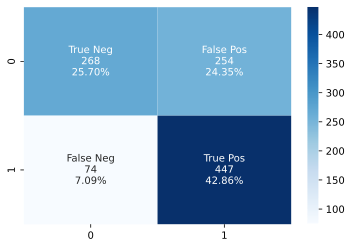

In [54]:
cm = [cm_before_under[0][0], cm_before_under[0][1], cm_before_under[1][0], cm_before_under[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones del clasificador de imagenes (submuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

Predicciones despues de la red bayesiana (submuestreo)


<AxesSubplot:>

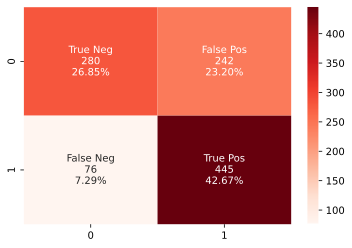

In [55]:
cm_bnn_pyAgrum_under = confusion_matrix(true_labels_test_under, 
                                          np.where(np.array(bn_new_predictions_under) > 0.5, 1, 0))

cm = [cm_bnn_pyAgrum_under[0][0], cm_bnn_pyAgrum_under[0][1], 
      cm_bnn_pyAgrum_under[1][0], cm_bnn_pyAgrum_under[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones despues de la red bayesiana (submuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')

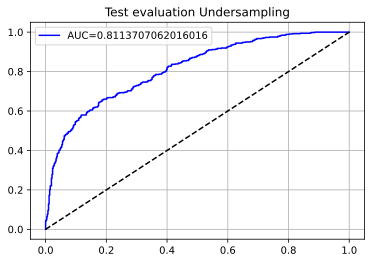

In [56]:
fpr, tpr, tr = metrics.roc_curve(true_labels_test_under, bn_new_predictions_under)
auc = metrics.roc_auc_score(true_labels_test_under, bn_new_predictions_under)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation Undersampling')
plt.grid()
plt.legend(loc='best')
plt.show()

Predicciones del clasificador de imagenes (weighted)


<AxesSubplot:>

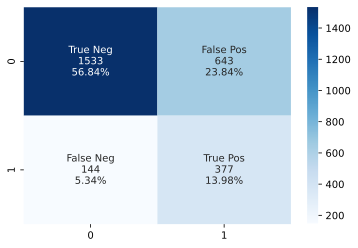

In [57]:
cm = [cm_before_weight[0][0], cm_before_weight[0][1], cm_before_weight[1][0], cm_before_weight[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones del clasificador de imagenes (weighted)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

Predicciones despues de la red bayesiana (weighted)


<AxesSubplot:>

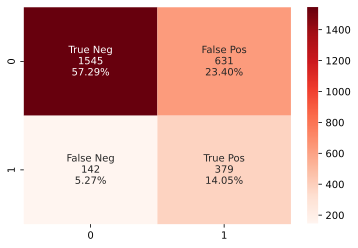

In [58]:
cm_bnn_pyAgrum_weight = confusion_matrix(true_labels_test_weight, 
                                          np.where(np.array(bn_new_predictions_weight) > 0.5, 1, 0))

cm = [cm_bnn_pyAgrum_weight[0][0], cm_bnn_pyAgrum_weight[0][1], 
      cm_bnn_pyAgrum_weight[1][0], cm_bnn_pyAgrum_weight[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones despues de la red bayesiana (weighted)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')

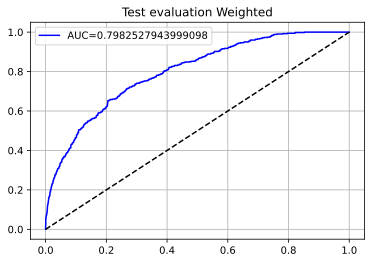

In [65]:
fpr, tpr, tr = metrics.roc_curve(true_labels_test_weight, bn_new_predictions_weight)
auc = metrics.roc_auc_score(true_labels_test_weight, bn_new_predictions_weight)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation Weighted')
plt.grid()
plt.legend(loc='best')
plt.show()

Predicciones del clasificador de imagenes (sobremuestreo)


<AxesSubplot:>

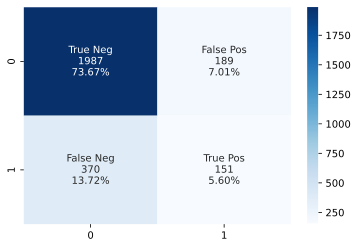

In [60]:
cm = [cm_before_over[0][0], cm_before_over[0][1], cm_before_over[1][0], cm_before_over[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones del clasificador de imagenes (sobremuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Blues')

Predicciones despues de la red bayesiana (sobremuestreo)


<AxesSubplot:>

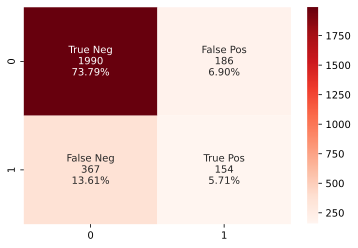

In [61]:
cm_bnn_pyAgrum_over = confusion_matrix(true_labels_test_over, 
                                          np.where(np.array(bn_new_predictions_over) > 0.5, 1, 0))

cm = [cm_bnn_pyAgrum_over[0][0], cm_bnn_pyAgrum_over[0][1], 
      cm_bnn_pyAgrum_over[1][0], cm_bnn_pyAgrum_over[1][1]]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm]
group_percentages = ["{0:.2%}".format(value) for value in cm/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Predicciones despues de la red bayesiana (sobremuestreo)")
sns.heatmap([[cm[0], cm[1]], [cm[2], cm[3]]], annot=labels, fmt='', cmap='Reds')

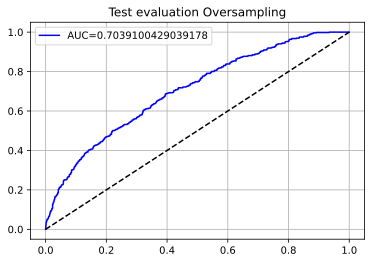

In [64]:
fpr, tpr, tr = metrics.roc_curve(true_labels_test_over, bn_new_predictions_over)
auc = metrics.roc_auc_score(true_labels_test_over, bn_new_predictions_over)
plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Test evaluation Oversampling')
plt.grid()
plt.legend(loc='best')
plt.show()